Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
import numpy as np
from numpy.random import normal
from collections import defaultdict
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

## Sample (and silly) startegies 

In [4]:
# Given the current state, this function returns all the possible moves.
def all_possible_moves(state: Nim) -> list:
    all_moves = []
    for row in [r for r, c in enumerate(state.rows) if c > 0]:
        upper_bound_for = (
            min(state.rows[row], state._k) + 1
            if state._k
            else state.rows[row] + 1
        )
        for obj_to_take in range(1, upper_bound_for):
            all_moves.append(Nimply(row, obj_to_take))
    return all_moves

In [5]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    return random.choice(all_possible_moves(state))

In [6]:
# 2.1 agent in slides
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [
        (r, o)
        for r, c in enumerate(state.rows)
        for o in range(1, min(c, state._k) + 1 if state._k else c + 1)
    ]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

In [7]:
# nim_sum: function often used in the mathematical analysis of the game to find winning strategies.
# https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html#:~:text=To%20win%20at%20Nim%2Dgame,error%20in%20order%20to%20win.
def nim_sum(state: Nim) -> int:
    # tmp: for each row, transform the number of object in that row to its binary form (width 32 bit), binary as a tuple of bits
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int(
        "".join(str(_) for _ in xor), base=2
    )  # convert the string of bit in its integer form


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (
        Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)
    ):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [
        ply for ply, ns in analysis["possible_moves"].items() if ns != 0
    ]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Functions needed to play and plot

In [8]:
def plot(
    wins_over_games_list: list, n_games, player0: callable, player1: callable
):
    # PLOT
    games_list = range(1, n_games + 1)
    wins_0_over_games_list = (
        np.array([x[0] for x in wins_over_games_list])
        / np.array(games_list)
        * 100
    )
    wins_1_over_games_list = (
        np.array([x[1] for x in wins_over_games_list])
        / np.array(games_list)
        * 100
    )

    plt.stackplot(
        games_list,
        wins_0_over_games_list,
        wins_1_over_games_list,
        colors=["b", "r"],
        labels=[
            f"Player 0 [{player0.__name__}]",
            f"Player 1 [{player1.__name__}]",
        ],
    )
    plt.legend(loc="lower right")
    plt.xlabel("Game")
    plt.ylabel("% Wins")


def simplified_match_for_new_agents(
    agent: callable,
    opponent: callable,
    nim_rows: int = 5,
    nim_k: int = None,
    n_games: int = 500,
) -> list:
    logging.getLogger().setLevel(logging.INFO)

    # toss a coin for who starts
    if random.random() > 0.5:
        strategy = (agent, opponent)
        num_agent = 0
    else:
        strategy = (opponent, agent)
        num_agent = 1

    wins_agent = 0  # wins of agent
    wins_opponent = 0  # wins of opponents

    # useful for plotting only
    wins_over_games_list = (
        []
    )  # for each game [(win_0, win_1), (win_0, win_1), ...]

    with tqdm(total=n_games, desc="Game: ") as pbar:
        for _ in range(n_games):
            nim = Nim(nim_rows, nim_k)
            # logging.info(f"init : {nim}")
            player = 1
            while nim:
                ply = strategy[player](nim)
                # logging.info(f"ply: player {player} plays {ply}")
                nim.nimming(ply)
                # logging.info(f"status: {nim}")
                player = 1 - player
            # logging.info(f"status: Player {player} won!")
            if player == num_agent:
                wins_agent += 1
            else:
                wins_opponent += 1
            # update stats for plot
            wins_over_games_list.append((wins_agent, wins_opponent))
            pbar.update(1)

    print(f"{int(wins_agent/n_games *100)}% of wins")
    plot(wins_over_games_list, n_games, agent, opponent)

## Other strategies results

Game:   0%|          | 0/500 [00:00<?, ?it/s]

Game: 100%|██████████| 500/500 [00:00<00:00, 800.76it/s]


53% of wins


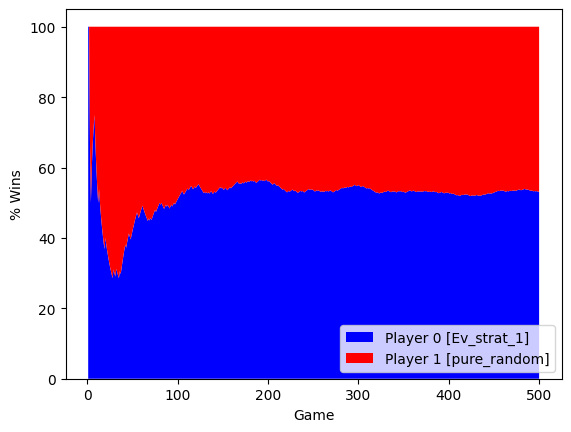

In [9]:
# Almost as good as the pure random.
from other_strategies import Ev_strat_1

N_GAMES = 500
ev_strat_1 = Ev_strat_1()
agent = ev_strat_1
opponent = pure_random
simplified_match_for_new_agents(
    agent=agent, opponent=opponent, nim_rows=5, n_games=N_GAMES
)

Game: 100%|██████████| 500/500 [00:08<00:00, 55.68it/s]


86% of wins


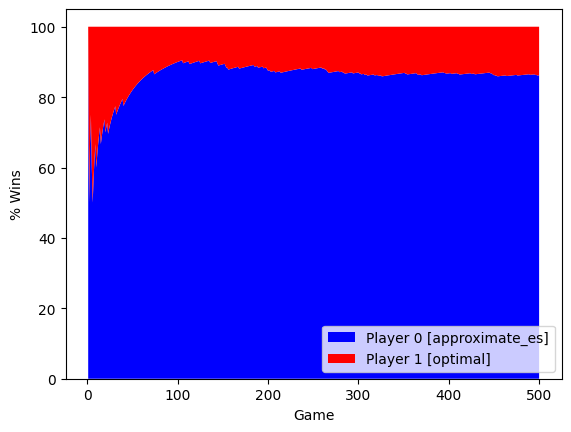

In [15]:
from other_strategies import approximate_es

N_GAMES = 500
agent = approximate_es
opponent = optimal
simplified_match_for_new_agents(
    agent=agent, opponent=opponent, nim_rows=5, n_games=N_GAMES
)

Game:   0%|          | 0/500 [00:00<?, ?it/s]

Game: 100%|██████████| 500/500 [01:23<00:00,  6.02it/s]

93% of wins


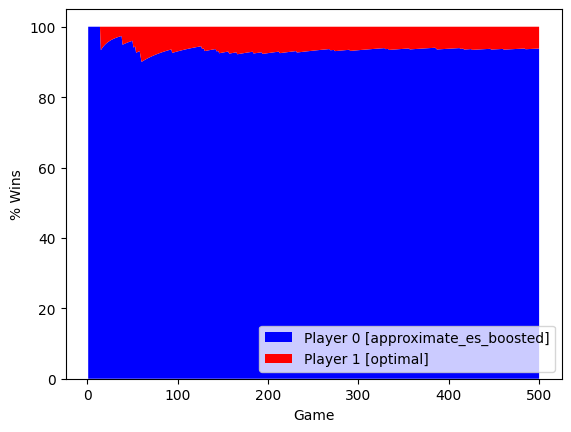

In [11]:
from other_strategies import approximate_es_boosted

N_GAMES = 500
agent = approximate_es_boosted
opponent = optimal
simplified_match_for_new_agents(
    agent=agent, opponent=opponent, nim_rows=5, n_games=N_GAMES
)

## Evolution strategy

In [26]:
# This function takes as input:
# The current state of the game.
# A list of possible moves to do in this current state.
# The number of games to play against the opponent.
# The opponent to play against.
# It returns as output:
# A dictionary composed of all the first moves made with their number of wins
def fitness(
    state: Nim,
    moves: list,
    n_games_per_move: int = 5,
    adversarial_strategy: callable = pure_random,
) -> dict:
    evaluated_moves = defaultdict(int)
    # for each move we will play n_games.
    for first_move in moves:
        for _ in range(n_games_per_move):
            nim = deepcopy(state)
            strategy = (pure_random, adversarial_strategy)
            # player is 0 because we are the one that moves.
            player = 0
            is_first = True
            while nim:
                if is_first:
                    # the first move is aways the move we are iterating.
                    ply = first_move
                    is_first = False
                else:
                    ply = strategy[player](nim)
                nim.nimming(ply)
                player = 1 - player
            # add 1 to the first move value if we won using that move, 0 otherway
            evaluated_moves[first_move] += 1 if player == 0 else 0
    return evaluated_moves


# Given all the possible moves in a state, the parent index and the standard deviation, tweak returns
# a new offspring.
def tweak(all_moves: list, parent_index: int, sigma: int) -> Nimply:
    valid_index = False
    while not valid_index:
        gaussian_parameter = normal(0, sigma)
        new_index = round(parent_index + gaussian_parameter)
        if -1 < new_index < len(all_moves):
            valid_index = True
    return all_moves[new_index]


# Given the current state, all the new offsprings, the parent and the adversarial strategy,
# return the best one between the offsprings and the parent, based on the fitness evaluation.
# Change the sigma value based on the percentage of offsprings better than the parent.
# Returns the best one and the new sigma value.
def survival_selection(
    state: Nim,
    offsprings: list,
    parent: Nimply,
    sigma: float,
    adversarial_strategy: callable = pure_random,
) -> (Nimply, int):
    # offsprings becomes all the moves to evaluate.
    offsprings.append(parent)
    evaluated_moves = fitness(
        state, offsprings, adversarial_strategy=adversarial_strategy
    )
    # select the best one
    best_one, _ = max(evaluated_moves.items(), key=lambda i: i[1])
    fitness_val_parent = evaluated_moves[parent]
    num_better_moves = 0
    # number of offsprings better than the parent
    for _, val in evaluated_moves.items():
        if fitness_val_parent < val:
            num_better_moves += 1
    # we use len(offsprings) -1 because at the beginning we add the parent to the offspring list.
    if num_better_moves / (len(offsprings) - 1) < 0.2:
        sigma *= 1.1
    else:
        sigma /= 1.1

    return (best_one, sigma)


# Given the current state, the old parent, the list of all parents and the tournamemnt size,
# the function selects randomly size-1 new possible parents and evaluate with the best_old_one.
# Returns the best new parent.
def tournament_selection(
    state: Nim, best_old_one: Nimply, all_parents: list, size: int
) -> Nimply:
    parents_selected = [random.choice(all_parents) for _ in range(size - 1)]
    parents_selected.append(best_old_one)
    evaluated_parents = fitness(state, parents_selected)
    best_parent, _ = max(evaluated_parents.items(), key=lambda i: i[1])
    return best_parent


# Given the state of the nim, select a parent, create offsprings, select the best one.
# Repeat for the num of generations.
# Returns the best move
def real_es(state: Nim) -> Nimply:
    # generation num set to 10 because gives good results and make the evaluation of 500 games reasonable.
    # for better results we could increase it.
    NUM_GENERATION = 50
    all_parents = all_possible_moves(state)
    best_one = random.choice(all_parents)
    # sigma initialization
    sigma = len(all_parents) / 5
    for _ in range(NUM_GENERATION):
        best_old_one = best_one
        # tournament size depends on the number of all possible parents.
        tournament_size = len(all_parents) // 5
        # select the best parent with tournament selection.
        best_parent = tournament_selection(
            state, best_old_one, all_parents, tournament_size
        )
        # Offspring generation
        index_of_best_parent = all_parents.index(best_parent)
        all_moves = all_parents  # just for readability
        # create 10 offsprings.
        n_offsprings = 10
        offsprings = []
        for _ in range(n_offsprings):
            offspring = tweak(all_moves, index_of_best_parent, sigma)
            offsprings.append(offspring)
        # survival selection between new offsprings and the parent.
        adversarial_strategy = pure_random
        best_one, sigma = survival_selection(
            state,
            offsprings,
            best_parent,
            sigma,
            adversarial_strategy=adversarial_strategy,
        )
    return best_one

Game: 100%|██████████| 500/500 [02:54<00:00,  2.87it/s]

81% of wins


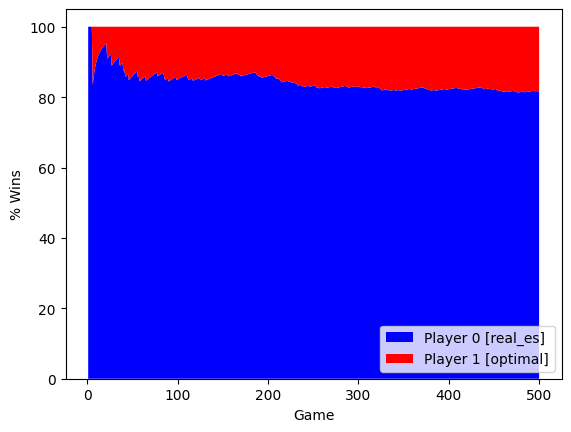

In [29]:
N_GAMES = 500
agent = real_es
opponent = optimal
simplified_match_for_new_agents(
    agent=agent, opponent=opponent, nim_rows=5, n_games=N_GAMES
)